# Power system optimization problem-2  



## 1.1 Objective


This section provides a comprehensive exploration of power system optimization by formulating and solving a **single-period economic dispatch with network-constraint** on a modified PJM 5-bus test system. The primary goal is to demonstrate the application of state-of-the-art optimization frameworks and computational tools in modeling complex power system operations, with a focus on balancing economic efficiency, operational reliability, and computational scalability. Electric grid operators must strategically schedule generation resources to meet forecasted electricity demand while minimizing costs, adhering to physical grid constraints, and ensuring stability across transmission networks.

The workflow is implemented using an open-source computational stack, including **Python** for scripting, **Jupyter Notebook** for interactive modeling and visualization, **NumPy** for numerical data processing, **GurobiPy** (via the Gurobi solver) to formulate and solve the linear programming (LP) problem, and **Matplotlib** for visualizing generation schedules. By combining theoretical principles with hands-on coding, this module illustrates how advanced optimization techniques can address real-world power system challenges, bridging the gap between academic research and industry-grade operational tools.



**## 1.2 Key Components**  

1. **Mathematical Model Formulation for single-period economic dispatch without network-constraint**  
   - **Objective Function:** Define a cost-minimization objective that aggregates generation costs for a single period.  
   - **Constraints:** Incorporate critical operational limits, including:  
     - **Generation capacity constraints** (minimum/maximum active power output for each generator).   
     - **Power balance constraints** ensuring supply meets demand at each bus.
     - **Transmission constraints** (thermal limits on line flows, calculated via Power Transfer Distribution Factors (PTDFs) to model network congestion).       

2. **System Parameter Configuration**  
   - **Input Data:** Structured datasets defining generator and load characteristics.
   - **Shift Factor Matrix (PTDF):** Compute the sensitivity matrix that maps power injections at buses to line flows, derived from the system’s admittance matrix. This matrix is critical for enforcing transmission constraints and identifying congestion patterns.  

3. **Optimization Problem Implementation and Solution**  
   - **Solver Integration:** Utilize **GurobiPy** (or equivalent solvers) to translate the mathematical model into a solver-readable format.  
   - **Model Building:** Programmatically declare decision variables, objective function, and constraints within a **Python**-based framework, leveraging **NumPy** for efficient matrix operations.   

4. **Result Extraction and Visualization**  
   - **Key Outputs:** Extract extract optimization results.  
   - **Visualization Tools:** Use **Matplotlib** and **Jupyter Notebook** to generate plots. 

---

**Module Impact:**  
This componentized workflow provides hands-on training in modern grid optimization, emphasizing the integration of **cyber infrastructure** (open-source tools, high-performance computing) with power system fundamentals. By decomposing the single-period economic dispatch without network-constraint problem into structured phases—model design, data engineering, solver implementation, and analytics—the module bridges theoretical optimization concepts with industry-relevant computational workflows. Participants gain proficiency in leveraging advanced packages, preparing them for research or operational roles in power systems.

<br><br>

# 2. Formulating the mathematical model for the optimization problem

This section breaks down the mathematical model used in the single-period economic dispatch without network-constraint problem. This problem aims to schedule power generation at the lowest possible cost. Below, we explain each component of the model in simple terms, using practical examples and analogies to help new learners grasp the concepts.

**Objective Function**

The objective function is to minimize the generation cost for a single period, where $P_{i}$ represents the active power output of generator $i$ in this period, $C_g(P_{i})$ denotes the generation cost of generator $i$ in this time period, $N_g$ is the total number of generators.

$$\min \sum_{i=1}^{N_g} C_g(P_{i})  \qquad (1)$$


**Constraints**

1. **Line flow limit constraints**

Line flow limit constraints, where GSF represents the shift factor matrix which can be calculated using the network admittance matrix, and $P_{l}^{max}$ denotes the line flow limit.

$$\sum_{i=1}^{N_{i}}GSF_{l-i}*P_{i}-\sum_{k=1}^{N_{l}}GSF_{l-k}*D_{k}\geq -P_{l}^{max}  \qquad (2)$$

$$\sum_{i=1}^{N_{i}}GSF_{l-i}*P_{i}-\sum_{k=1}^{N_{l}}GSF_{l-k}*D_{k}\leq P_{l}^{max}  \qquad (3)$$

**Intuition Behind GSF:**
GSF values act like "traffic coefficients." For example, if $GSF_{l−i}=0.3$, 30% of the power from generator i flows through line l. These factors depend on the grid’s physics (line impedances, topology).

**Why This Matters:**
If too much power flows through a line, it can fail (e.g., during a heatwave). The ED model ensures flows stay within limits.

2. **Power Balance Constraint**

System load balance constraints, where $D_{k}$ represents the load at bus $k$, and $K$ denotes the total number of buses.

$$\sum_{i=1}^{N_{g}} P_{i} \geq \sum_{k=1}^{K}D_{k} \qquad (4)$$

**Why Equality vs. Inequality?**
While the equation uses ≥, in practice, generation should exactly match demand to avoid grid instability. This constraint assumes excess power can be curtailed (e.g., renewables) or stored.


3. **Generator output limit constraints**

Generator output limit constraints, where $P_{i}^{max}$ and $P_{i}^{min}$ represent the upper and lower output limits of generator $i$, respectively.

$$P_{i}^{min}\leq P_{i}\leq P_{i}^{max}  \qquad (5)$$

**Why Use DC Power Flow?**

The model simplifies the grid’s physics using DC power flow assumptions:

Lossless Lines: No energy is lost as heat.

Flat Voltage: Voltage magnitudes are constant, and angles are small.

Linear Equations: Makes the problem a linear program (LP), which is fast to solve even for large grids.

**Trade-Off:**

Real grids use AC power flow (nonlinear), but solving AC is computationally expensive. DC flow is a "good enough" approximation for day-ahead planning.


**Summary**

This model balances cost, reliability, and physics:

Minimize costs while respecting generator limits.

Ensure supply meets demand.

Use linear equations for speed and simplicity.

**Next Steps:**

In practice, you’ll code this model using optimization tools like Gurobi. Each constraint translates to a line of code, and the solver finds the optimal generator outputs!

<br><br>

# 3. Modified PJM 5-bus system

## 3.1 Overview
The PJM 5-bus system was originally published as early as 1999 [1]. This system ishown in Fig. 1 [1], which includes a total of 5 buses, 6 lines, 5 generators, and 3 loads. Based on the PJM 5-bus system used in [1], our module introduces several modifications to the parameters. Further details are presented in the following sections.


![Fig. 1. The PJM 5-bus system [1]](pjm5bus_diagram.png)

**Fig. 1. The PJM 5-bus system [1]**



## 3.2 Generator parameters
The parameters of the generators are presented below. Each generator's ramp rate is set to 50% [2] of its maximum power output, and the minimum power output for each generator is assumed to be 20% of its maximum power output.


| Name | Location | Ramping limit (MW) | Min (MW) | Max (MW) | Price ($/MWh) |
|------------------|----------|--------------------|--------|--------|---------------|
| Alta             | Bus A    | 55                | 22      | 110    | 14            |
| Park City        | Bus A    | 50                | 20      | 100    | 15            |
| Solitude         | Bus C    | 260               | 104     | 520    | 20            |
| Sundance         | Bus D    | 100               | 40      | 200    | 19            |
| Brighton         | Bus E    | 300               | 120     | 600    | 10            |


## 3.3 Line parameters
The parameters of the lines are presented below. 

| Line | From bus | To bus | Reactance p.u. | Flow Limit MW |
|------|----------|--------|----------------|---------------|
| A-B  | A        | B      | 0.0281         | 400          |
| A-D  | A        | D      | 0.0304         | 300          |
| B-C  | B        | C      | 0.0108         | 400          |
| C-D  | C        | D      | 0.0297         | 400          |
| D-E  | D        | E      | 0.0297         | 240          |
| E-A  | E        | A      | 0.0064         | 300          |


## 3.4 Load parameters
The load for each bus throughout the 24 hours is presented below. However, for our single-period economic dispatch without network constraints in this section, we only use the data from Hour 12. The 24-hour data will be used in the subsequent multi-period network-constrained economic dispatch problem.

| Bus | Hour 1 | Hour 2 | Hour 3 | Hour 4 | Hour 5 | Hour 6 | Hour 7 | Hour 8 | Hour 9 | Hour 10 | Hour 11 | Hour 12 | Hour 13 | Hour 14 | Hour 15 | Hour 16 | Hour 17 | Hour 18 | Hour 19 | Hour 20 | Hour 21 | Hour 22 | Hour 23 | Hour 24 |
|-----|--------|--------|--------|--------|--------|--------|--------|--------|--------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
| Bus A | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 |
| Bus B | 181.72 | 196.03 | 210.33 | 224.64 | 238.94 | 245.90 | 252.86 | 259.81 | 266.77 | 273.73 | 280.69 | 287.64 | 294.60 | 276.22 | 257.84 | 239.46 | 221.09 | 234.59 | 248.09 | 261.59 | 275.08 | 251.65 | 228.21 | 204.78 |
| Bus C | 184.62 | 194.86 | 205.11 | 215.36 | 225.60 | 235.62 | 245.64 | 255.67 | 265.69 | 275.71 | 285.73 | 295.75 | 305.77 | 289.15 | 272.53 | 255.91 | 239.30 | 251.58 | 263.86 | 276.15 | 288.43 | 262.07 | 235.70 | 209.34 |
| Bus D | 274.10 | 289.67 | 305.23 | 320.80 | 336.37 | 344.47 | 352.58 | 360.68 | 368.79 | 376.89 | 385.00 | 393.10 | 401.21 | 383.78 | 366.36 | 348.93 | 331.51 | 344.62 | 357.73 | 370.85 | 383.96 | 358.45 | 332.94 | 307.43 |
| Bus E | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 |


## References
[1] F. Li and R. Bo, "Small Test Systems for Power System Economic Studies," 2010 IEEE PES General Meeting, Minneapolis, MN, USA, 2010, pp. 1-4, doi: 10.1109/PES.2010.5589973.

[2] X. Fang, F. Li, Y. Wei, and H. Cui, "Strategic scheduling of energy storage for load serving entities in locational marginal pricing market," IET Generation, Transmission & Distribution, vol. 9, no. 4, pp. 358–365, Apr. 2015, doi: 10.1049/iet-gtd.2015.0144.


<br><br>

# 4. Inputting system parameters









First, numpy [1] is imported for scientific computing and efficient array operations. NumPy is a powerful array programming library in Python, widely used across different fields for scientific research and data analysis. Serving as the foundation of the scientific Python ecosystem, NumPy offers powerful data manipulation interfaces and acts as an interoperability layer between various array computation libraries [1].


In [1]:
import numpy as np

To facilitate programming, we will use the terms 'generator 1', 'generator 2', 'generator 3', 'generator 4', 'generator 5' to refer respectively to the generators Alta, Park City, Solitude, Sundance, and Brighton. Similarly, 'line 1', 'line 2', 'line 3', 'line 4', 'line 5' will correspond to the lines A-B, A-D, B-C, C-D, D-E, and E-A.
Then, we record the number of generators, lines, and buses used in the modified PJM 5-bus system employed in this module, designating bus 1 as the reference bus. 

In [2]:
N_gen= 5
N_line=6
bus_num=5
ref_bus = 1

Thereafter, we set generators' maximum outputs:

In [3]:
gen_max=np.zeros(N_gen)
gen_max[0]=110
gen_max[1]=100
gen_max[2]=520
gen_max[3]=200
gen_max[4]=600
print("Gen_max:")
print(gen_max)

Gen_max:
[110. 100. 520. 200. 600.]


Subsequently, we set generators' minimum outputs, the minimum outputs of the generators are assumed to be 20% of their maximum outputs:

In [4]:
gen_min=np.zeros(N_gen)
gen_min=0.2*gen_max
print("Gen_min:")
print(gen_min)

Gen_min:
[ 22.  20. 104.  40. 120.]


Next, we set the generators' costs, here we assume each unit has a fixed cost per MWh of output:

In [5]:
gen_cost=np.zeros(N_gen)
gen_cost[0]=14
gen_cost[1]=15
gen_cost[2]=20
gen_cost[3]=19
gen_cost[4]=10
print("Gen_cost:")
print(gen_cost)

Gen_cost:
[14. 15. 20. 19. 10.]


Then, we set the load forecast for each bus the studied period. For this single-period economic dispatch without network constraints problem, we only use the load data from Hour 12 as an example.

In [6]:
load = np.array([
    [  0.  ],
    [287.64],
    [295.75],
    [393.10],
    [  0.  ]
])
load = load.flatten() 
print("Load:")
print(load)

Load:
[  0.   287.64 295.75 393.1    0.  ]


Next, we set the line flow limit for each transmission line:

In [7]:
line_max=np.zeros(N_line)
line_max[0]=400
line_max[1]=300
line_max[2]=400
line_max[3]=400
line_max[4]=240
line_max[5]=300
print("Line_flow_limit:")
print(line_max)

Line_flow_limit:
[400. 300. 400. 400. 240. 300.]


Subsequently, we set the line's impedance parameters. Here we only consider reactance:

In [8]:
branch_data = [
    (1, 1, 2, 0.0281),
    (2, 1, 4, 0.0304),
    (3, 2, 3, 0.0108),
    (4, 3, 4, 0.0297),
    (5, 4, 5, 0.0297),
    (6, 5, 1, 0.0064),
]

Following this, we can calculate the B_matrix, which is the foundation for calculatig the Shift Factors matrix.

In [9]:
B_matrix = np.zeros((N_gen, N_gen))
for _, i, j, reactance in branch_data:
    i, j = i - 1, j - 1
    Y = 1 / reactance
    B_matrix[i][j] = B_matrix[j][i] = -Y
for i in range(N_gen):
    B_matrix[i][i] = -np.sum(B_matrix[i])
print("B_matrix:")
print(B_matrix)

B_matrix:
[[ 224.73192545  -35.58718861    0.          -32.89473684 -156.25      ]
 [ -35.58718861  128.1797812   -92.59259259    0.            0.        ]
 [   0.          -92.59259259  126.26262626  -33.67003367    0.        ]
 [ -32.89473684    0.          -33.67003367  100.23480418  -33.67003367]
 [-156.25          0.            0.          -33.67003367  189.92003367]]


Based on the previously calculated B matrix, we can now calculate the system's Shift Factors matrix:

In [10]:
def calculate_shift_factors(B_matrix, branch_data, inj_bus, ref_bus):
    n = B_matrix.shape[0]
    B_reduce = np.delete(np.delete(B_matrix, ref_bus - 1, axis=0), ref_bus - 1, axis=1)
    delta_P = np.zeros(n)

    delta_P[ref_bus - 1] = -1
    delta_P[inj_bus - 1] = delta_P[inj_bus - 1]+1
    delta_P_reduce = np.delete(delta_P, ref_bus - 1, axis=0)

    delta_theta = np.linalg.solve(B_reduce, delta_P_reduce)

    delta_theta = np.insert(delta_theta, ref_bus - 1, 0)

    SF_matrix = np.zeros(len(branch_data))

    for index, (branch, i, j, reactance) in enumerate(branch_data):
        i, j = i - 1, j - 1
        SF_matrix[index] = (delta_theta[i] - delta_theta[j]) / reactance

    return SF_matrix

SF=np.zeros((N_line,bus_num))

for inj_bus in range(bus_num):

    SF[:,inj_bus] = calculate_shift_factors(B_matrix, branch_data, inj_bus+1, ref_bus)

print("Shift Factors matrix:")
print(SF)

Shift Factors matrix:
[[ 0.         -0.66981132 -0.54290606 -0.19391661 -0.03437857]
 [ 0.         -0.17924528 -0.24813671 -0.43758813 -0.07757795]
 [ 0.          0.33018868 -0.54290606 -0.19391661 -0.03437857]
 [ 0.          0.33018868  0.45709394 -0.19391661 -0.03437857]
 [ 0.          0.1509434   0.20895723  0.36849527 -0.11195652]
 [ 0.          0.1509434   0.20895723  0.36849527  0.88804348]]


## References

[1] Harris, C.R., Millman, K.J., van der Walt, S.J. et al. Array programming with NumPy. Nature 585, 357–362 (2020). DOI: 10.1038/s41586-020-2649-2.

<br><br>

# 5. Formulating the optimization problem in cyber infrastructure and solving the optimization problem

We use Gurobipy [1] to model and solve this mathematical formulation. The Gurobi Optimizer is a mathematical optimization software designed to solve a wide range of optimization problems [2]. Gurobipy is the official Python interface provided by Gurobi, enabling seamless integration of the optimizer within Python environments for efficient model building and solution processes. The Gurobipy package includes a trial license, which allows users to solve problems of limited size [2]. However, students and faculty affiliated with academic institutions are eligible for a free, full-featured license [2].

First, if you have not installed Gurobipy, you can install it in Jupyter Notebook using the following command:

In [11]:
#install gurobipy
get_ipython().run_line_magic('pip', 'install gurobipy')

Note: you may need to restart the kernel to use updated packages.


Next, you need to import the entire gurobipy library and import the GRB constants from gurobipy.

In [12]:
import gurobipy as grb
from gurobipy import GRB

Following this, you will use gurobipy to construct a day-ahead economic dispatch optimization model. The first steps are to create a new optimization model instance, define the decision variables, and set up the objective function.

In [13]:
#create a new optimization model
M = grb.Model()
#define the decision variables
P_i = M.addVars(N_gen, vtype = GRB.CONTINUOUS, name='gen_output')
#set up the objective function
gen_fuel_cost = grb.quicksum(gen_cost[i]*(P_i[i]) for i in range(N_gen))
M.setObjective(gen_fuel_cost, GRB.MINIMIZE)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-10


Next, you need to define various constraints, such as line flow limit constraints:

In [14]:
M.addConstrs((SF[l,0]*(P_i[0]+P_i[1])+SF[l,2]*P_i[2]+SF[l,3]*P_i[3]+
              SF[l,4]*P_i[4]-(SF[l,0]*load[0]+SF[l,1]*load[1]+SF[l,2]*load[2]+
                                  SF[l,3]*load[3]+SF[l,4]*load[4]) <= line_max[l]
              for l in range(N_line) ),name='con_1')
M.addConstrs((SF[l,0]*(P_i[0]+P_i[1])+SF[l,2]*P_i[2]+SF[l,3]*P_i[3]+
              SF[l,4]*P_i[4]-(SF[l,0]*load[0]+SF[l,1]*load[1]+SF[l,2]*load[2]+
                                  SF[l,3]*load[3]+SF[l,4]*load[4]) >= -line_max[l]
              for l in range(N_line) ),name='con_2')
M.update()

System load balance constraints:

In [15]:
M.addConstr((grb.quicksum(P_i[i] for i in range(N_gen)) >=
              grb.quicksum(load[p] for p in range(bus_num)) ),name='con_3')
M.update()

Generator output limit constraints:

In [16]:
M.addConstrs((P_i[i] <= gen_max[i] for i in range(N_gen) ),name='con_4')
M.addConstrs((P_i[i] >=gen_min[i]  for i in range(N_gen) ),name='con_5')
M.update()

Now, you can invoke Gurobi to solve this optimization problem using the following command:

In [17]:
M.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-12500H, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 23 rows, 5 columns and 51 nonzeros
Model fingerprint: 0xd3566540
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+01, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+03]
Presolve removed 20 rows and 0 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 11 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2380499e+04   4.168303e+01   0.000000e+00      0s
       3    1.2887038e+04   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.288703839e+04


From the solution results presented above, it can be observed that the computational time for solving this optimization problem was 0.01 seconds, with an optimal objective value of 1.288703839e+04.

## References

[1] Gurobi Optimization, LLC, “Gurobi Optimizer Reference Manual,” 2024.

[2] Gurobi Optimization, LLC, “GurobiPy: Python interface for the Gurobi Optimizer,” PyPI, [Online]. Available: https://pypi.org/project/gurobipy/


<br><br>

# 6. Extracting the optimization results and displaying the outcomes

First, we extract the decision variables corresponding to the solution of our optimization model:

In [18]:
#Extract optimization results
P_i_1 = np.zeros(N_gen)
for i in range(0,N_gen):
    P_i_1[i] =  P_i[i].X

Next, we import matplotlib.pyplot [1] to display the results mentioned above. The matplotlib.pyplot module provides a suite of functions designed to emulate MATLAB-like functionality within Matplotlib, facilitating interactive plotting and visualization in Python [2].

In [19]:
#Import matplotlib.pyplot for plotting
import matplotlib.pyplot as plt

Then, we can display the results using matplotlib.pyplot:

Set the font size in the figure to 16:

In [20]:
plt.rcParams.update({'font.size': 16})

Set the figure size to figsize=(9, 5):

In [21]:
plt.figure(figsize=(9, 5))

<Figure size 900x500 with 0 Axes>

<Figure size 900x500 with 0 Axes>

Set the line styles and markers:

In [22]:
line_styles = ['-', '--', '-.', ':', (0, (3, 10, 1, 10))]
markers = ['o', 's', '^', 'D', 'x']

Plot the output of each generator across all time periods, then configure the display characteristics of the legend, x-axis, and y-axis, then generate the figure:

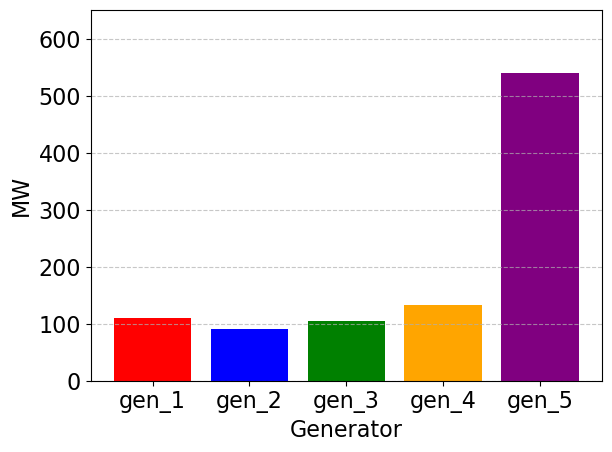

In [23]:
labels = ['gen_1', 'gen_2', 'gen_3', 'gen_4', 'gen_5']
x = np.arange(len(P_i_1))  

plt.bar(x, P_i_1, color=['red', 'blue', 'green', 'orange', 'purple'])

plt.xticks(x, labels)
plt.xlabel('Generator')
plt.ylabel('MW')
plt.ylim(0, 650)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Building on the optimization results for the decision variables obtained above, further analytical calculations can be conducted. For instance, we can determine the scheduling cost for each generating unit:

In [24]:
#Calculate each generator's cost
individual_gen_cost=np.zeros(N_gen)
for i in range(N_gen):
    individual_gen_cost[i]=gen_cost[i]*P_i_1[i]
    print(f'Operating cost of individual gen {i+1}: {individual_gen_cost[i]:.2f}')

Operating cost of individual gen 1: 1540.00
Operating cost of individual gen 2: 1351.02
Operating cost of individual gen 3: 2080.00
Operating cost of individual gen 4: 2516.02
Operating cost of individual gen 5: 5400.00


## References

[1] J. D. Hunter, "Matplotlib: A 2D graphics environment," Computing in Science & Engineering, vol. 9, no. 3, pp. 90-95, 2007, doi: 10.1109/MCSE.2007.55.

[2] Matplotlib Developers, "Pyplot tutorial," Matplotlib Documentation, https://matplotlib.org/stable/tutorials/pyplot.html 